# Optimizers

**A must read:**
https://cs231n.github.io/neural-networks-3/#ada

Training a machine learning model means **searching for the best set of parameters that minimizes the loss function**, a measure of how far your model’s predictions are from the actual targets.
- Imagine this search as navigating a **complex, high-dimensional surface**: there are many possible routes or `paths` a model can follow to reach the lowest point (minimum loss) on this surface.

- To efficiently and reliably reach this goal, specialized algorithms—called **optimizers**—are used.
  - Optimizers guide the parameter updates during training, helping the network quickly move towards the minimum, avoiding poor paths, and ideally finding the best solution.
- Because **different problems and surfaces pose different challenges**, researchers have developed a variety of optimizers, such as **Gradient Descent, RMSProp, Adam, and others**, each with unique strategies for navigating the loss landscape and overcoming issues **like slow convergence or getting stuck in local minima**.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

import tensorflow as tf
from tensorflow.keras import optimizers

The objective of any deep learning algorithm is to find the optimal weights `w` that minimize the loss function `L(w)` to improve model performance.

  - A core principle to achieve the objective is `Iterative refinement`.

### Strategy 1: Random Search (Baseline - Poor Performance)

**Concept**: Test random weight combinations and select the best performer. It is the first (very bad) idea that may come to mind is to simply try out many different random weights and keep track of what works best.

Let's assume a loss function:

$$
\frac{1}{2}\sum_{i}w_i^2 \;+\; 0.1\sum_{i}\sin\bigl(10\,w_i\bigr)
$$

In [ ]:
def sample_loss(w):
    return 0.5*np.sum(w**2) + 0.1 * np.sum(np.sin(10 * w))
result = minimize(sample_loss, [0, 100])
print(f'The solution of optimization x: {result.x}')
print(f'Value of objective function at x: {result.fun}')

The solution of optimization x: [-0.14275498  0.96788874]
Value of objective function at x: 0.35447966927707736


In [ ]:
lst_loss = []

# A function to calculate best weight and minimum loss
def random_search_optimizer(loss_fn, W_shape, num_iterations=1000):
  best_W = np.random.randn(*W_shape)
  best_loss = loss_fn(best_W)
  # Till specified number of iterations randomly generate w and
  for i in range(num_iterations):
    W_random = np.random.randn(*W_shape)
    loss = loss_fn(W_random)
    lst_loss.append(loss)
    if loss < best_loss:
      best_W = W_random
      best_loss = loss
  return best_W, best_loss, lst_loss

In [ ]:
def loss_function(w):
    return 0.5*np.sum(w**2) + 0.1*np.sum(np.sin(10 * w))

In [ ]:
W_optimal, final_loss, lst_loss = random_search_optimizer(sample_loss, (10, 5))
print(f"Best loss: {final_loss}")

Best loss: 12.526635675169464


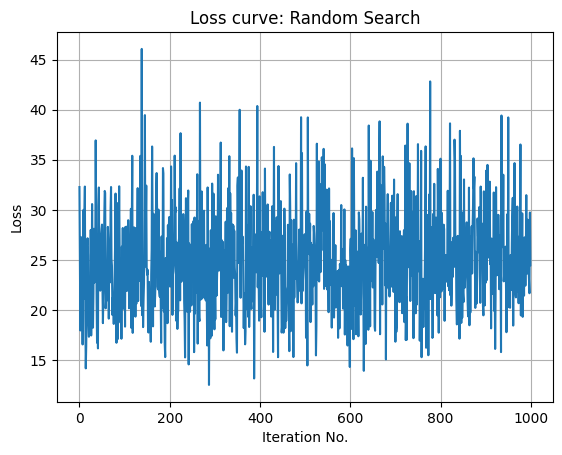

In [ ]:
# Loss curve
plt.plot(lst_loss)
plt.title('Loss curve: Random Search')
plt.xlabel('Iteration No.')
plt.ylabel('Loss')
plt.grid()
plt.show()

 **Limitation**: Computationally inefficient and lacks direction.

 - It turns out that we can do much better. The **core idea is that finding the best set of weights W is a very difficult** or even impossible problem, but the problem of **refining a specific set of weights W to be slightly better** is significantly less difficult.

 - In other words, our approach will be to start with a random `w` and then iteratively refine it, making it slightly better each time.

**Our strategy will be to start with random weights and iteratively refine them over time to get lower loss**

**Blindfolded hiker analogy:** One analogy that you may find helpful going forward is to think of yourself as hiking on a hilly terrain with a blindfold on, and trying to reach the bottom. At every point on the hill we achieve a particular loss (the height of the terrain).

### Strategy 2: Random Local Search (Slight Improvement)

**Concept**: Make small random perturbations δW around current position; accept only improvements.

In [ ]:
def random_local_search(loss_fn, W_init, step_size=0.01, num_iterations=1000):
  W = W_init.copy()
  current_loss = loss_fn(W)
  loss_history = [current_loss]

  for i in range(num_iterations):
      # Generate random perturbation
      delta_W = np.random.randn(*W.shape) * step_size
      W_new = W + delta_W
      new_loss = loss_fn(W_new)

      # Accept if improvement
      if new_loss < current_loss:
          W = W_new
          current_loss = new_loss

      loss_history.append(current_loss)

  return W, loss_history

In [ ]:
W_init = np.random.randn(10, 5)
W_final, history = random_local_search(loss_function, W_init)
W_final

array([[-0.1289823 ,  1.11756165,  0.94234488, -0.62813883,  0.82485478],
       [-0.66687728, -0.73710494,  1.07207258,  0.40219659,  0.97594588],
       [-0.13246804,  0.39786777,  0.48846701, -0.08387767,  0.42733685],
       [ 1.01559903,  0.45857812, -0.6759837 , -0.14518897, -0.67321594],
       [-1.40506432, -0.65571574, -0.05884558, -0.5731113 , -0.21792186],
       [ 0.54329254,  0.45188621,  0.36175193, -0.68035423,  0.38816705],
       [-0.64622442, -0.76421336, -0.7644928 , -0.71876442,  0.41176617],
       [-0.16128076,  0.30060252,  0.39272007,  0.38416254, -0.10475951],
       [-0.28210523,  1.00038443,  0.48950885,  0.98529014,  0.4839643 ],
       [ 0.43381003, -0.70449808, -0.71173995, -0.30254326,  0.81955993]])

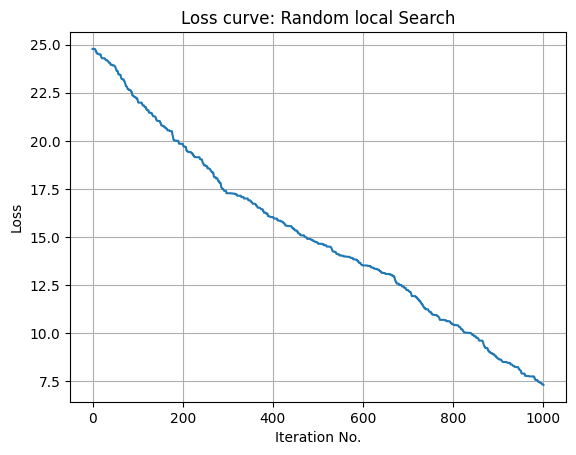

In [ ]:
# Loss curve
plt.plot(history)
plt.title('Loss curve: Random local Search')
plt.xlabel('Iteration No.')
plt.ylabel('Loss')
plt.grid()
plt.show()

### Strategy 3: Gradient Descent (Optimal Direction)

In the previous strategy we tried to find a direction in the weight-space that would improve our weight vector (and give us a lower loss).

- It turns out that there is no need to randomly search for a good direction: we can compute the best direction along which we should change our weight vector that is mathematically guaranteed to be the direction of the steepest descent (at least in the limit as the step size goes towards zero). **This direction will be related to the gradient of the loss function.**

- In our hiking analogy, this approach roughly corresponds to feeling the slope of the hill below our feet and stepping down the direction that feels steepest.

- The **gradient is a generalization of slope for functions that don’t take a single number but a vector of numbers**. Additionally, the gradient is just a vector of slopes (more commonly referred to as derivatives) for each dimension in the input space.

- When the **functions of interest take a vector of numbers instead of a single number, we call the derivatives partial derivatives**, and the gradient is simply the vector of partial derivatives in each dimension.

**Mathematical Foundation**:
- **1D Derivative**: $$ \frac{df(x)}{dx} = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h} $$
- **Gradient**: Vector of partial derivatives $$ \nabla_W f = [\frac{\partial f}{\partial w_1}, \frac{\partial f}{\partial w_2}, ..., \frac{\partial f}{\partial w_n}] $$


**There are two ways to compute the gradient:**
- A slow, approximate but easy way (numerical gradient), and
- A fast, exact but more error-prone way that requires calculus (analytic gradient).

**Computational Complexity**
- **Numerical**: O(n) function evaluations per iteration
- **Analytical**: O(1) function evaluation per iteration
- **Conclusion**: Analytical gradients essential for large networks

#### Numeric Gradient

In [ ]:
def numerical_gradient(loss_fn, W, h=1e-5):
    """
    Compute numerical gradient using finite differences
    """
    grad = np.zeros_like(W)

    # Iterate over each weight
    for i in range(W.size):
        # Flatten for indexing
        W_flat = W.flatten()

        # Compute f(x + h)
        W_flat[i] += h
        loss_pos = loss_fn(W_flat.reshape(W.shape))

        # Compute f(x - h)
        W_flat[i] -= 2*h
        loss_neg = loss_fn(W_flat.reshape(W.shape))

        # Restore original value
        W_flat[i] += h

        # Centered difference formula
        grad.flat[i] = (loss_pos - loss_neg) / (2 * h)

    return grad

In [ ]:
# Gradient Descent Implementation
def gradient_descent(loss_fn, W_init, learning_rate=0.01, num_iterations=1000):
    W = W_init.copy()
    loss_history = []

    for i in range(num_iterations):
        # Compute gradient
        grad = numerical_gradient(loss_fn, W)

        # Update weights (negative gradient direction)
        W = W - learning_rate * grad

        # Record loss
        current_loss = loss_fn(W)
        loss_history.append(current_loss)

        if i % 100 == 0:
            print(f"Iteration {i}: Loss = {current_loss:.6f}")

    return W, loss_history

In [ ]:
W_init = np.random.randn(10, 5)
weights, hist = gradient_descent(loss_function, W_init)

Iteration 0: Loss = 21.720043
Iteration 100: Loss = 5.919772
Iteration 200: Loss = 4.732212
Iteration 300: Loss = 4.732212
Iteration 400: Loss = 4.732212
Iteration 500: Loss = 4.732212
Iteration 600: Loss = 4.732212
Iteration 700: Loss = 4.732212
Iteration 800: Loss = 4.732212
Iteration 900: Loss = 4.732212


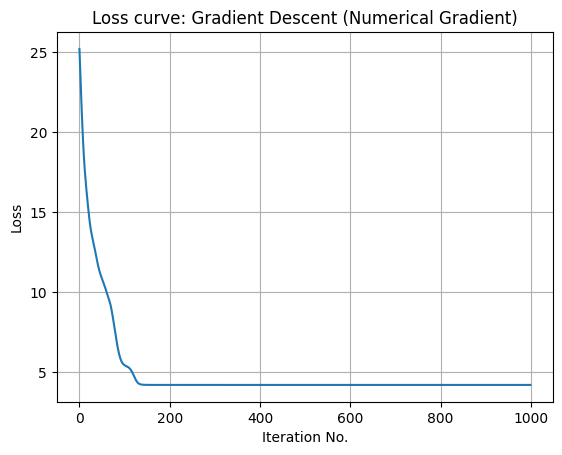

In [ ]:
# Loss curve
plt.plot(hist)
plt.title('Loss curve: Gradient Descent (Numerical Gradient)')
plt.xlabel('Iteration No.')
plt.ylabel('Loss')
plt.grid()
plt.show()

#### Analytical Gradient

$$
\frac{\partial}{\partial W_i}\!\Biggl(\frac{1}{2}\sum_{j}W_j^2 \;+\; 0.1\sum_{j}\sin(10W_j)\Biggr)
= W_i \;+\; 0.1 \cdot 10 \cos\bigl(10W_i\bigr)
= W_i \;+\; \cos\bigl(10W_i\bigr)
$$

Thus, in vector form:
$$
\nabla_W f(W) = W \;+\; \cos\bigl(10W\bigr).
$$

In [ ]:
def analytical_gradient(W):
  """
  Compute analytical gradient of loss function
  """
  return W + np.cos(10*W)

In [ ]:
# Gradient Descent Implementation
def gradient_descent(loss_fn, W_init, learning_rate=0.01, num_iterations=1000):
  W = W_init.copy()
  loss_history = []

  for i in range(num_iterations):
      # Compute gradient
      grad = analytical_gradient(W)

      # Update weights (negative gradient direction)
      W = W - learning_rate * grad

      # Record loss
      current_loss = loss_fn(W)
      loss_history.append(current_loss)

      if i % 100 == 0:
          print(f"Iteration {i}: Loss = {current_loss:.6f}")

  return W, loss_history

In [ ]:
W_init = np.random.randn(10, 5)
weights, hist = gradient_descent(loss_function, W_init)

Iteration 0: Loss = 25.232046
Iteration 100: Loss = 6.795672
Iteration 200: Loss = 5.695496
Iteration 300: Loss = 5.695495
Iteration 400: Loss = 5.695495
Iteration 500: Loss = 5.695495
Iteration 600: Loss = 5.695495
Iteration 700: Loss = 5.695495
Iteration 800: Loss = 5.695495
Iteration 900: Loss = 5.695495


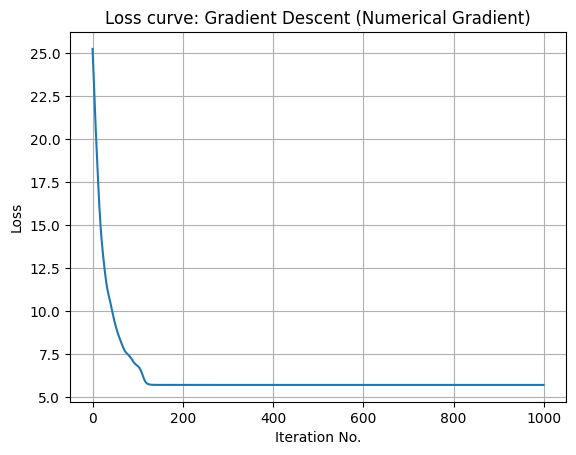

In [ ]:
# Loss curve
plt.plot(hist)
plt.title('Loss curve: Gradient Descent (Numerical Gradient)')
plt.xlabel('Iteration No.')
plt.ylabel('Loss')
plt.grid()
plt.show()

**Step Size (Learning Rate)**
- **Too small**: Slow convergence
- **Too large**: Overshooting, unstable training
- **Solution**: Learning rate scheduling or adaptive methods

| Method | Speed | Accuracy | Scalability |
|--------|-------|----------|-------------|
| Random Search | Very Slow | Poor | No |
| Random Local Search | Slow | Fair | No |
| Numerical Gradient | Slow | Good | Limited |
| Analytical Gradient | **Fast** | **Excellent** | **Yes** |

**Bottom Line**: Modern deep learning relies on analytical gradients with efficient backpropagation algorithms for scalable optimization.

## Overview of Optimization Algorithms in Deep Learning

### First-Order Methods

**Efficiency:** First-order methods like SGD are computationally cheaper but may require more iterations; second-order methods converge faster but are expensive.

These algorithms use the **first derivative (gradient)** of the loss function to update parameters:

- **Stochastic Gradient Descent (SGD):**  
  The most fundamental algorithm that updates weights **using gradients estimated from small randomly selected mini-batches**, making it computationally efficient for large datasets.

- **Adaptive Methods:**  
  Aim to **adjust learning rates** for individual parameters **based on past gradient information.**
  
  Examples include:
  - **Adagrad:** **Increases the learning rate for infrequent features**, but may slow down over time.
  - **Adadelta:** Addresses **Adagrad’s diminishing learning rate** by restricting accumulation to a fixed-size window.
  - **RMSprop:** Uses an **exponentially decaying average of squared gradients** to maintain adaptive learning rates without rapid decay.

### Second-Order Methods

Incorporate second derivatives (Hessian) to estimate curvature information for more precise updates:
- **Newton’s Method**
- **Conjugate Gradient:**  
  Can converge faster but computationally expensive due to Hessian calculations, making them less common in deep learning.

### Momentum-Based Methods

**Acceleration:** Momentum-based methods speed up training by reducing oscillations and helping escape flat regions or saddle points.

Use velocity concepts to accelerate convergence and help overcome saddle points:
- **Momentum:** Aggregates past gradients to smooth updates.
- **Nesterov Accelerated Gradient (NAG):** Improves on momentum by looking ahead before computing gradient.
- **Adam:** Combines momentum with adaptive learning rates, computing first and second moment estimates of gradients.
- **Nadam:** Adam variant incorporating Nesterov momentum.

### Advanced Adaptive Gradient Methods

**Adaptivity:** Adjusting learning rates dynamically per parameter allows training to be more effective on sparse or noisy data.

**Robustness:** Methods like Adam provide stable convergence across various architectures and datasets, often the default choice in practice.

Further refine adaptivity to learning rates:
- **AdaMax:** An extension of Adam using the infinity norm.
- **AMSGrad:** Addresses convergence issues of Adam by maintaining the maximum of past squared gradients.

| Algorithm       | Characteristics                         | Pros                              | Cons                              |
|-----------------|---------------------------------------|----------------------------------|----------------------------------|
| SGD             | Basic gradient descent with sampling  | Simple, scalable                 | May converge slowly, requires tuning |
| Adagrad         | Per-parameter adaptive learning rates | Effective for sparse data        | Learning rate decays too aggressively |
| RMSprop         | Exponential moving average of gradients | Prevents excessive decay        | Requires careful hyperparameter tuning |
| Adam            | Momentum + adaptive learning rates    | Fast convergence, robust         | More memory usage, can overfit  |
| Nesterov (NAG)  | Look-ahead momentum                   | Improved momentum                | Slightly more complex            |
| AdaMax          | Variant of Adam with infinity norm   | More stable in some cases        | Less widespread use              |
| AMSGrad         | Modification of Adam for convergence | Better theoretical guarantees   | Slightly slower in practice      |

## Gradient Descent

#### **What is Gradient Descent?**


Gradient descent is the foundational optimization algorithm used to train models in deep learning and many other machine learning approaches. It's the method behind training everything from
- simple linear regression,
- single neurons,
- multi-layer neural networks,
- convolutional neural networks (CNNs),
- recurrent neural networks (RNNs), and non-neural models like
- K-means clustering and
- matrix factorization.

#### **Why Do We Use Gradient Descent?**

- Our goal in training models is to **minimize a loss function** $L$ (also called cost or error) with respect to model parameters ($w$, $b$, etc.).
- In calculus, to minimize a function $f(x)$, take the derivative, set it to zero, and solve for $x$.
- But in deep learning (and other complex models), *closed-form solutions* for minima almost never exist due to the complexity and nonlinearity of the function.
- Thus, we use **numerical approximation**: an iterative approach to move towards the function's minimum by following the slope.

#### **Why Not Just Solve the Derivative?**


- For some functions, like $f(x) = 5x^2 + 3x + 1$, you can solve $\frac{df}{dx}=0$ analytically.
- For most deep learning loss functions:
  - The function is too complex/high-dimensional.
  - No closed-form solution exists; numerical iteration is needed.

**Example:**

Suppose the loss is $$L(w) = w^2$$
- The gradient is $2w$.
- The update rule becomes:
  $$
  w \leftarrow w - \eta \cdot 2w = w(1 - 2\eta)
  $$
- Repeatedly applying this update brings $w$ closer to 0, the minimum of $w^2$.

#### **Gradient Descent Intuition**


- **Idea:** At each step, move the parameters a small distance in the direction where the loss decreases fastest—the negative gradient.
- The learning rate ($\eta$) controls the step size.

**Gradient Descent Update Equation**

For parameter $w$, the basic update rule is:
$$
w \leftarrow w - \eta \frac{\partial L(w)}{\partial w}
$$
- $\eta$ : Learning rate (step size)
- $\frac{\partial L}{\partial w}$: Gradient of the loss with respect to $w$

#### **Gradient Descent pseudocode**


```python
w = random_initial_value
for step in range(num_epochs):
    gradient = dL/dw(w)
    w = w - eta * gradient
```

### Gradient Descent Variants

Optimizers differ by the amount of data used to compute each update, trading off update accuracy against computation time.

#### Batch Gradient Descent  

- Calculates the gradient of the loss using the *entire dataset*, **then updates parameters once per epoch.**
- **Stable convergence but slow and memory-intensive for large datasets.**
- Loss function: $$ L = \frac{1}{n} \sum_{i=1}^n \frac{1}{2}(y_i - \hat{y}_i)^2 $$ where $ n $ = size of dataset.

- Compute the gradient over the entire dataset before each update:
$$
w_{new} \leftarrow w_{old} - \eta\,\nabla_w J(w).
$$
  -  **Pros:** Guaranteed convergence to global minimum for convex losses; stable updates.  
  -  **Cons:** Extremely slow for large datasets; requires full dataset in memory; not suitable for online learning.  

```
for epoch in 1…N:
  grad = ∇wJ(w; all data)
  w ← w - η·grad
```

#### 2. Stochastic Gradient Descent (SGD)

- Updates parameters after *each data point* (i.e., batch size = 1) by randomly shuffling and sampling one data point at a time.
- Much faster updates, but high variance in loss curve, can lead to instability.
- Loss at each step: $$ L = \frac{1}{2}(y_j - \hat{y}_j)^2 $$ for data point $ j $, update after every data point.
- Update parameters using one example at a time:
$$
w_{new} \leftarrow w_{old} - \eta\,\nabla_w J(w; x^{(i)},y^{(i)}).
$$

  -  **Pros:** Fast updates; online learning possible; can escape shallow local minima due to noisy updates.  
  -  **Cons:** High variance in loss (fluctuations); convergence requires decaying learning rate.  

```
for epoch in 1…N:
  shuffle(data)
  for each (x,y) in data:
    grad = ∇wJ(w; x, y)
    w ← w - η·grad
```

**Why Stochastic?**

Imagine you want to find the average height of all people in the world, but there are 7 billion people. Measuring every individual is practically impossible and time-consuming. Instead, **measuring the height of a random sample of 1000 people can give a very close estimate of the true average, saving tremendous time.**

- Similarly, in deep learning, calculating the overall gradient (which guides the model’s learning) requires summing over all training samples. This can be computationally expensive when datasets are very large.

- SGD approximates this by computing the gradient using a **random subset** of data points (called a mini-batch) instead of the entire dataset. This introduces a level of randomness (stochasticity) but drastically reduces computation time.

#### 3. Mini-Batch Gradient Descent  


- Compromise: uses *batches* of $ k $ samples ($ 8, 16, 32, 64, 128, 256$ etc.) to update parameters.
- Achieves balance between fast updates and stable convergence; enables vectorization and efficient memory use.
- Loss per batch: $$ L = \frac{1}{k} \sum_{i=1}^k \frac{1}{2}(y_i - \hat{y}_i)^2 $$

**Parameter update rule for all variants:**

- Compromise using batches of size B:
$$
w \leftarrow w - \eta\,\nabla_w J(w; x^{(i:i+B)},y^{(i:i+B)}).
$$
  -  **Pros:** Reduces variance for more stable convergence; exploits matrix operations for efficiency.  
  -  Typical Batches: 32, 64, 128, 256 samples.

```
for epoch in 1…N:
  shuffle(data)
  for batch in data.split_batches(B):
    grad = ∇θJ(θ; batch)
    w ← w - η·grad
```

Mini-batch gradient descent involves training a model on small subsets of the dataset instead of the entire set at once. For instance, with a dataset of $ n = 20,000 $ data points, training happens on minibatches each containing $ m = 50 $ data points.

- The loss function is modified from the full dataset average:  
$$
L = \frac{1}{n} \sum_{i=1}^n L\bigl(M(x_i), y_i\bigr)
$$
to the minibatch average:  
$$
L = \frac{1}{m} \sum_{i=1}^m L\bigl(M(x_i), y_i\bigr)
$$

- Weights are updated after each minibatch is processed—through one feedforward pass and one backpropagation pass—resulting in  
$$
\frac{n}{m} = \frac{20,000}{50} = 400
$$
updates per epoch.

- This approach offers several benefits:  

  - **Efficient GPU utilization:** Smaller batch sizes fit better in memory, reducing the time needed for each update.  
  - **Parallelism:** Minibatches can be further split into smaller units, enabling parallel feedforward and backpropagation. Gradients from these smaller units are averaged to update weights effectively.

- Mini-batch gradient descent offers computational advantages but also has a drawback:
  - minibatches may be **biased toward certain features**. For example, one minibatch might contain mostly taller people while another contains mostly shorter people, which can negatively affect training.
  - To address this, we **reshuffle the entire training dataset before performing minibatch gradient descent**. This ensures that each minibatch better represents the entire dataset without bias. Note that this reshuffling happens only once per epoch because it is computationally expensive.

**This balances computational efficiency with stable learning during model training. Additionally the batch sizes chosen are typically powers of 2 to optimize computational efficiency.**

**In deep learning research and practice, mini-batch SGD is most widely used due to its stability, speed, and suitability for modern datasets and hardware.**


| Method         | Data Used Per Update | Updates/Epoch | Convergence     | Memory Use     |
| -------------- | ------------------- | ------------- | --------------- | -------------- |
| SGD            | 1 sample            | n             | Fast, unstable  | Low            |
| Batch GD       | All data            | 1             | Slow, stable    | High           |
| Mini-batch GD  | k samples           | n/k           | Fast, stable    | Moderate       |

### SGD in Keras: Any size batch of data

- In TensorFlow 2.0, typical gradient descent is implemented as "SGD".
- The batch size controls the mini-batch sampling size.
- Comparing training with full batch and small batch size typically shows faster convergence and reduced runtime with small batches.








#### How Does SGD Work?

- The dataset is divided into small mini-batches, typically of size 32, 64, or 128.
- For each mini-batch, the algorithm computes the average loss and its gradient.
- Parameters (weights) are updated based on this mini-batch gradient.
- This process is repeated across all mini-batches to complete one **epoch**.
- The data is shuffled at each epoch to avoid learning biases due to data ordering.

### Practical Challenges

1. **Learning Rate Selection:** Choosing a proper learning rate can be difficult.   
   -  **Too small** → slow convergence  
   -  **Too large** → loss function to fluctuate around the minimum or even to diverge. Divergence or Oscillation  

2. **Learning Rate Schedules**  
   -  Pre-defined decay schedules i.e.,when the change in objective between epochs falls below a threshold (annealing) or adaptive triggers improve convergence but require hyperparameter tuning.

3. **Parameter-Wise Adaptation**  
   -  Uniform η may not suit sparse features and our features have very different frequencies; adaptive optimizers (AdaGrad, RMSProp, Adam) adjust per-parameter learning rates.

4. **Non-Convex Landscapes**  
   -  Saddle points (plateaus) impede progress more than local minima.  
   -  Noisy updates in SGD help escape saddles but complicate precise convergence.

5. **Number of epochs:**
    - Number of update steps; must be enough for convergence, but not so high as to waste computation.

**Convergence:** As updates continue, changes in the loss function become smaller, and parameters approach values that minimize loss.

Gradient descent is a fundamental optimizer valued for its simplicity and ease of implementation. However, it has **drawbacks** such as **getting stuck in local minima** and **following a zigzagging path** when the loss surface has steep slopes in one direction and gentle slopes in another.
  - Gradient descent can get stuck in local minima points in the loss landscape **that are lower than their immediate surroundings but not the absolute lowest point (global minimum)** meaning the algorithm may not always find the best solution, especially for complex models like neural networks
  - This **zigzag effect** occurs because **gradient descent moves more aggressively toward the steep slope**, causing oscillations and slowing convergence.
    - Gradient descent may **repeatedly overshoot in the steep direction while making slow progress in the gentle one**. This causes the optimization path to zigzag across the loss surface instead of moving directly toward the minimum, slowing down convergence and potentially causing instability in training.
  - These **limitations motivate the development of more advanced optimization algorithms** that can navigate the loss landscape more efficiently.

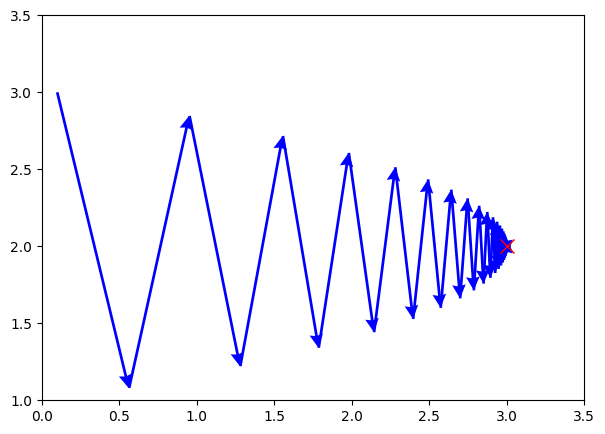

In [1]:
import numpy as np
import tensorflow as tf
from keras import optimizers
import matplotlib.pyplot as plt

# initial point and the target point
w0 = np.array([0.1, 3], dtype='float32') # initial point
wt = np.array([3, 2], dtype='float32')   # target point
w = tf.Variable(w0)                      # (w1, w2)

# Gradient Descent optimizer
opt = optimizers.SGD(learning_rate = 0.8, momentum=0.0)

def loss(w):
    return tf.reduce_sum(tf.square(w - wt) * [0.1, 1.2])

path = [w.numpy()]
for i in range(80):
    # perform automatic differentiation
    with tf.GradientTape() as tape:
        # the gradient of w1-axis is small,
        # and the gradient of w2-axis is large.
        dw = tape.gradient(loss(w), [w])

    # update w by gradient descent
    opt.apply_gradients(zip(dw, [w]))
    path.append(w.numpy())
path = np.array(path)

# visually check the path to the optimal point.
x, y = path[:, 0], path[:, 1]
plt.figure(figsize=(7, 5))
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
           color='blue', scale_units='xy',
           scale=1, width=0.005,
           headwidth=5)
plt.plot(wt[0], wt[1], marker='x', markersize=10, color='red')
plt.xlim(0, 3.5)
plt.ylim(1.0, 3.5)
plt.show()

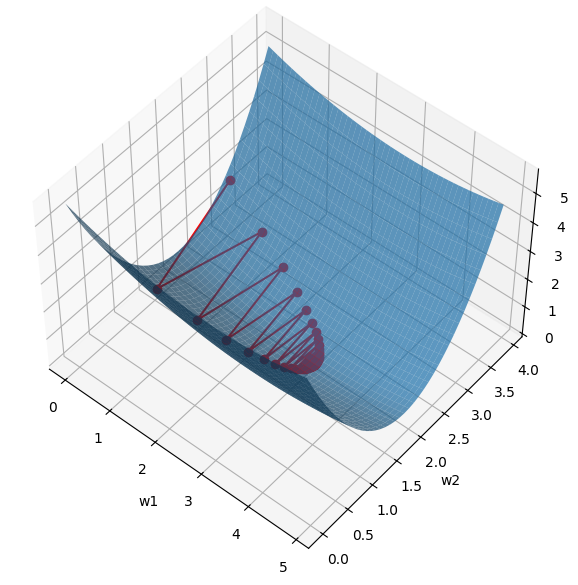

In [2]:
# Draw the loss surface and the path to the optimal point.
m = 5
t = 0.1
w1, w2 = np.meshgrid(np.arange(0, m, t), np.arange(0, 4, t))
zs = np.array([loss([a,b]).numpy() for [a, b] in zip(np.ravel(w1), np.ravel(w2))])
z = zs.reshape(w1.shape)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Draw the surface of the loss function
ax.plot_surface(w1, w2, z, alpha=0.7)

# Dwaw the path to the optimal point.
L = np.array([loss([a, b]).numpy() for [a, b] in zip(x, y)])
ax.plot(x, y, L, marker='o', color="r")

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('loss')
ax.azim = -50
ax.elev = 50
plt.show()

## Gradient Descent with Momentum

Momentum is one of the **most effective enhancements to plain gradient descent** in deep learning. It **speeds up training and helps overcome common optimization problems**.
-  Faster convergence, reduced oscillation, better navigation of shallow regions and saddle points, and more stable training.
- **Momentum** in gradient descent stores the direction and speed of previous updates, building up acceleration in consistent directions.
- **With momentum**, the cost function converges much faster than with plain gradient descent.

### Intuition

**SGD with Momentum**

- Imagine pushing a box across a frictionless surface like ice. If you **give it a push**, it **glides for a long distance** because it builds up momentum.
- The **box continues to move even after you stop pushing**, gently slowing down due to friction.
  - In gradient descent with momentum, your optimization travels across the error surface in a similar way.

**SGD without momentum (Standard Gradient Descent)**
- It is like pushing a box on sand the **box only moves as much as you push each time**. If you want to keep moving, you must push every time.
  - This is how plain gradient descent works: every step depends only on the current gradient, with no memory of past direction.

### Mathematical Formulation

**Standard Gradient Descent**

- The update rule for a parameter $ w $ is:
$$
w_{t+1} = w_t - \eta \cdot g(w_t)
$$
  where:
  - $ \eta $ is the learning rate,
  - $ g_t $ is the gradient of the loss at step $ t $.

- If the gradient is zero, $w$ does not change. $g(w_t) = 0$
$$
w_{t+1} = w_t - \eta \cdot (0)
$$
$$
w_{t+1} = w_t
$$

**Gradient Descent with Momentum**
- Momentum optimizer adds the current gradient to the previous momentum. This is the momentum vector. This vector remembers past gradients.
- Momentum introduces a **momentum** term, often denoted by $ m $:
$$
m_{t} = \beta \cdot m_{t-1} + \eta \cdot g(w_t)
$$
$$
w_{t+1} = w_{t} - m_{t}
$$
  where:
  - $ \beta $ (momentum coefficient) determines how much of the previous momentum is retained (e.g., 0.9, 0.95, or 0.99).
  - $ m_{t-1} $ is the previous momentum.
  - The gradient $ g_t $ represents the current "push."
- The parameter $w_{t+1}$ is u**pdated in the direction where the local gradient and previous momentum are combined.** It will accelerate the gradient descent towards the target point and dampen the oscillations.
- With $\beta$, a hyper-parameter the inertia of the distant past gradually weakens, and the inertia of the recent past takes
on greater weight.
- **Due to inertia**, the momentum optimizer may pass through a shallow local minimum or may take a different route.

- If you set $ \beta = 0 $, you recover standard gradient descent.
$$
w_{t+1} = w_{t} - \eta \cdot g(w_t)
$$

- If the gradient is zero, $w$ does not change. $g_t = 0$
$$
m_{t} = \beta \cdot m_{t-1} + \eta \cdot (0)
$$
$$
w_{t+1} = w_{t} - m_{t}
$$
- Weight update
$$
w_{t+1} = w_{t} - \beta m_{t-1}
$$

**Momentum allows the optimizer to `remember` past pushes, so even if the gradient is briefly zero, it can glide forward—just as a box slides across ice.**

### Why Momentum Works?

- The momentum term smooths the optimization path and accumulates direction, helping **the optimizer move through shallow regions and over small bumps in the error surface**.

- This accumulation helps speed up convergence, especially in **valleys and directions with a shallow gradient.**
- Near the minimum, updates slow down as friction (analogous to the decreasing contribution of past momentum) dampens movement, preventing overshooting.

**Suppose you have two parameters to optimize, one vertical and one horizontal. If the gradient is much steeper in one direction, plain gradient descent moves in the steepest direction. The result is a zig-zag path down the valley, which is inefficient.**

- Momentum solves this by accumulating velocity in the shallow direction, producing larger steps and smoothing out movement so you reach the minimum more directly.

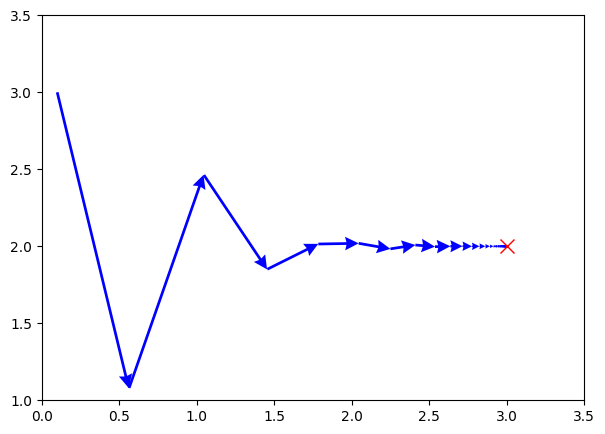

In [ ]:
import numpy as np
import tensorflow as tf
from keras import optimizers
import matplotlib.pyplot as plt

# initial point and the target point
w0 = np.array([0.1, 3], dtype='float32') # initial point
wt = np.array([3, 2], dtype='float32')   # target point
w = tf.Variable(w0)                      # (w1, w2)

# SGD with Mommentum
opt = optimizers.SGD(learning_rate = 0.8, momentum=0.2)
# opt = optimizers.Adagrad(learning_rate = 0.8)
# opt = optimizers.RMSprop(learning_rate = 0.2, rho=0.1)

def loss(w):
    return tf.reduce_sum(tf.square(w - wt) * [0.1, 1.2])

path = [w.numpy()]
for i in range(80):
    # perform automatic differentiation
    with tf.GradientTape() as tape:
        # the gradient of w1-axis is small,
        # and the gradient of w2-axis is large.
        dw = tape.gradient(loss(w), [w])

    # update w by gradient descent
    opt.apply_gradients(zip(dw, [w]))
    path.append(w.numpy())
path = np.array(path)

# visually check the path to the optimal point.
x, y = path[:, 0], path[:, 1]
plt.figure(figsize=(7, 5))
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
           color='blue', scale_units='xy',
           scale=1, width=0.005,
           headwidth=5)
plt.plot(wt[0], wt[1], marker='x', markersize=10, color='red')
plt.xlim(0, 3.5)
plt.ylim(1.0, 3.5)
plt.show()

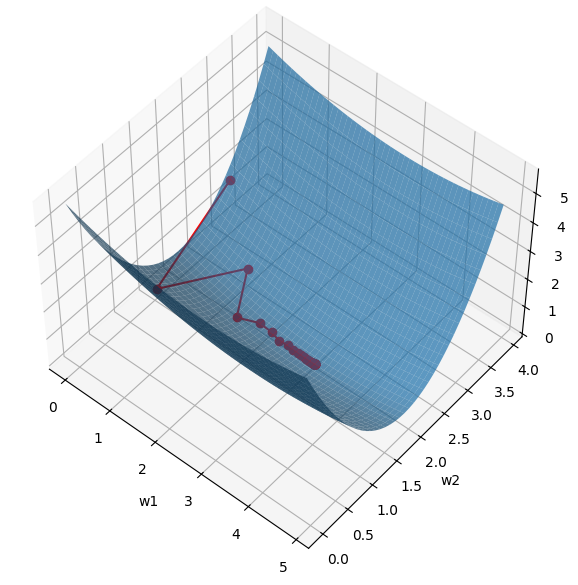

In [ ]:
# Draw the loss surface and the path to the optimal point.
m = 5
t = 0.1
w1, w2 = np.meshgrid(np.arange(0, m, t), np.arange(0, 4, t))
zs = np.array([loss([a,b]).numpy() for [a, b] in zip(np.ravel(w1), np.ravel(w2))])
z = zs.reshape(w1.shape)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Draw the surface of the loss function
ax.plot_surface(w1, w2, z, alpha=0.7)

# Dwaw the path to the optimal point.
L = np.array([loss([a, b]).numpy() for [a, b] in zip(x, y)])
ax.plot(x, y, L, marker='o', color="r")

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('loss')
ax.azim = -50
ax.elev = 50
plt.show()

## Gradient Descent with Nesterov Momentum

- Nesterov momentum is a improvement momentum in gradient descent, providing faster and more stable convergence.
- The **momentum optimizer has a disadvantage near the target point that it may pass the target point due to inertia**.
  - When w is far away from the target point, it can quickly approach the target point due to the **momentum effect**.
  - When w approaches the target point, it can stably reach the target point without deviating from the target point due to the **NAG effect**.
- NAG is an improvement on this. When determining $w_{t+1}$,
  - the momentum optimizer calculates the **local gradient at the current point**,
  - the NAG optimizer calculates the **local gradient at the point where momentum was applied**.


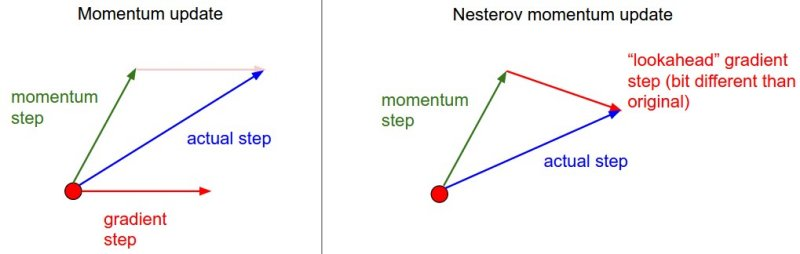

### Mathematical Formulation

- The differentiation point is different from the momentum optimizer.
  - *Momentum update:*
    $$
    m_t = \beta m_{t-1} + \eta \cdot g(w_{t} + \beta m_{t-1})
    $$
  - *Weight update:*
    $$
    w_{t+1} = w_{t} - m_t
    $$
- If $ \beta = 0 $, Nesterov momentum reduces to plain gradient descent.

$$
w_{t+1} = w_{t} - \eta \cdot g(w_t)
$$


### Why Use Nesterov Momentum?

- Instead of calculating the gradient at the current location,**computing the gradient at that anticipated next location** allows for smoother, more accurate updates that reduce overshooting and zigzagging.
  - Calculates the gradient where momentum will take you, allowing for early **correction and more responsive steps.**
  - Nesterov momentum can reach the **optimal solution more quickly**, especially in regions where the loss surface is steep in one direction but flat in another (common in deep networks).
  - Reduces **excessive oscillation and zigzagging**, allowing the optimizer to `glide` in shallow directions and correct itself before moving too far in steep directions.

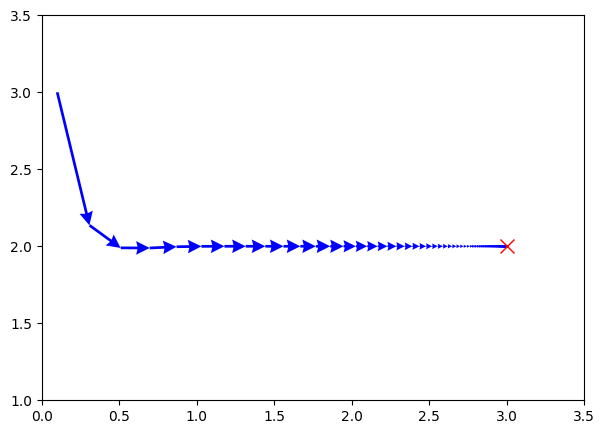

In [ ]:
import numpy as np
import tensorflow as tf
from keras import optimizers
import matplotlib.pyplot as plt

# initial point and the target point
w0 = np.array([0.1, 3], dtype='float32') # initial point
wt = np.array([3, 2], dtype='float32')   # target point
w = tf.Variable(w0)                      # (w1, w2)

# SGD with Nesterov Mommentum
opt = optimizers.SGD(learning_rate = 0.3, momentum=0.2, nesterov= True)

def loss(w):
    return tf.reduce_sum(tf.square(w - wt) * [0.1, 1.2])

path = [w.numpy()]
for i in range(80):
    # perform automatic differentiation
    with tf.GradientTape() as tape:
        # the gradient of w1-axis is small,
        # and the gradient of w2-axis is large.
        dw = tape.gradient(loss(w), [w])

    # update w by gradient descent
    opt.apply_gradients(zip(dw, [w]))
    path.append(w.numpy())
path = np.array(path)

# visually check the path to the optimal point.
x, y = path[:, 0], path[:, 1]
plt.figure(figsize=(7, 5))
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
           color='blue', scale_units='xy',
           scale=1, width=0.005,
           headwidth=5)
plt.plot(wt[0], wt[1], marker='x', markersize=10, color='red')
plt.xlim(0, 3.5)
plt.ylim(1.0, 3.5)
plt.show()

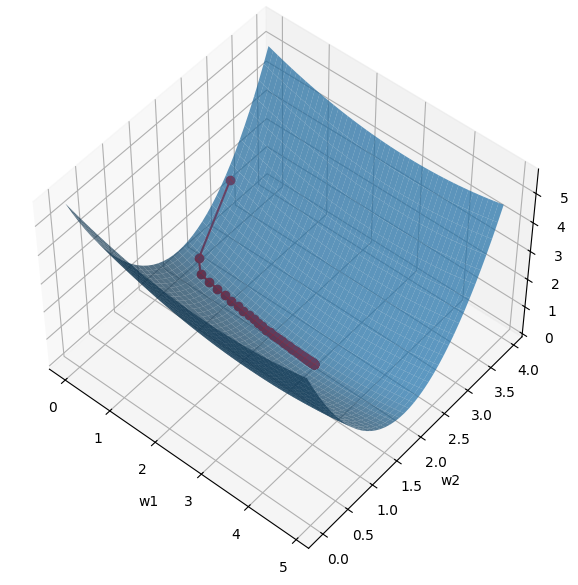

In [ ]:
# Draw the loss surface and the path to the optimal point.
m = 5
t = 0.1
w1, w2 = np.meshgrid(np.arange(0, m, t), np.arange(0, 4, t))
zs = np.array([loss([a,b]).numpy() for [a, b] in zip(np.ravel(w1), np.ravel(w2))])
z = zs.reshape(w1.shape)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Draw the surface of the loss function
ax.plot_surface(w1, w2, z, alpha=0.7)

# Dwaw the path to the optimal point.
L = np.array([loss([a, b]).numpy() for [a, b] in zip(x, y)])
ax.plot(x, y, L, marker='o', color="r")

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('loss')
ax.azim = -50
ax.elev = 50
plt.show()

## Variable and Adaptive Learning Rate Methods

In deep learning, **choosing the right learning rate is crucial for efficient and effective model training**. Beyond standard momentum methods, variable and adaptive learning rate techniques can significantly enhance training speed and stability.


- Adaptive learning rates aim to refine this process by:

  - Automatically **reducing the learning rate over time**.
  - Assigning **different learning rates to individual parameters** based on past gradient behavior.

- Standard Gradient Descent and Momentum does not account for the fact that at different stages of training, and across different parameters, the amount of adjustment needed varies considerably.

  - **Early training:** The parameters $ w $ are typically far from their optimal values, so it is beneficial to use a **large learning rate** to make substantial updates and quickly approach the optimum.
  - **Later training:** As $ w $ approaches the target point, the learning rate should **decrease**, allowing finer, more stable adjustments and preventing overshooting or oscillations around the minimum.

### AdaGrad (Adaptive Gradient Algorithm)

AdaGrad (Adaptive Gradient Algorithm) is one of the adaptive learning rate methods.

- **Per-parameter Adaptation:** Each parameter has its own learning rate, adjusted according to the magnitude of its gradients over time.
- **Variable $G_t$:** A running sum of squared gradients $ G_t $ (or cache/memory) is maintained for each parameter.
- **Adjustment Mechanism:**
  - Parameters with **large accumulated gradients** receive **smaller effective learning rates**—they update slowly since their loss landscape is steep.
  - Parameters with **small accumulated gradients** keep relatively **larger learning rates**—allowing them more opportunity to change when the landscape is flat or sparse.

#### Mathematical Formulation

1. **Initialization:**

   - Initialize $ G_0 = 0 $, a cache variable that accumulates squared gradients for each parameter.
   - Use a small constant $ \epsilon $ (e.g., $10^{-6}$) in denominators to prevent division by zero.

2. **At each iteration $ t $:**

   - Compute the gradient $ g_t $ of the loss with respect to the parameter.

   - Update the $G_t$:

     $$
     G_t = G_{t-1} + g_t^2
     $$

     Where the squared gradient is accumulated element-wise per parameter.

   - Update the parameter:

     $$
     w_{t+1} = w_t - \frac{\eta}{\sqrt{G_t + \epsilon}} g_t
     $$

     Where,
     - $ \eta $ is the global learning rate,
     - $ \sqrt{G_t + \epsilon} $  scales down the learning rate according to the historical magnitude of gradients for each parameter,
     - Effective learning rates decrease for heavily updated parameters and remain higher for less updated ones.


#### Limitations of Adagrad

- The accumulation of squared gradients $ G_t $ grows **exponentially** over time.
- This causes the effective learning rates to **decrease too quickly**, potentially halting training prematurely.
- As a result, while Adagrad excels in the initial phase of training, it can become overly conservative later.

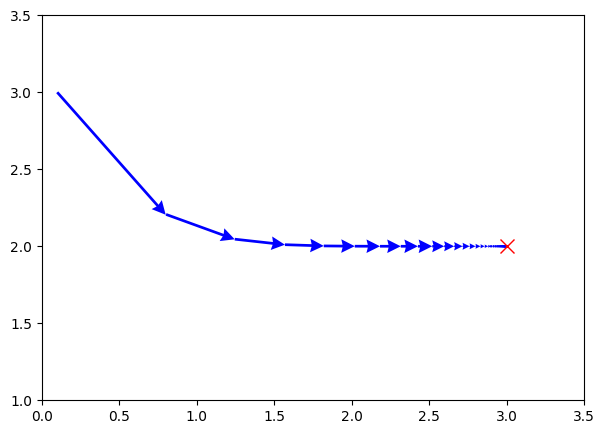

In [ ]:
import numpy as np
import tensorflow as tf
from keras import optimizers
import matplotlib.pyplot as plt

# initial point and the target point
w0 = np.array([0.1, 3], dtype='float32') # initial point
wt = np.array([3, 2], dtype='float32')   # target point
w = tf.Variable(w0)                      # (w1, w2)

# Adagrad
opt = optimizers.Adagrad(learning_rate = 0.8)

def loss(w):
    return tf.reduce_sum(tf.square(w - wt) * [0.1, 1.2])

path = [w.numpy()]
for i in range(80):
    # perform automatic differentiation
    with tf.GradientTape() as tape:
        # the gradient of w1-axis is small,
        # and the gradient of w2-axis is large.
        dw = tape.gradient(loss(w), [w])

    # update w by gradient descent
    opt.apply_gradients(zip(dw, [w]))
    path.append(w.numpy())
path = np.array(path)

# visually check the path to the optimal point.
x, y = path[:, 0], path[:, 1]
plt.figure(figsize=(7, 5))
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
           color='blue', scale_units='xy',
           scale=1, width=0.005,
           headwidth=5)
plt.plot(wt[0], wt[1], marker='x', markersize=10, color='red')
plt.xlim(0, 3.5)
plt.ylim(1.0, 3.5)
plt.show()

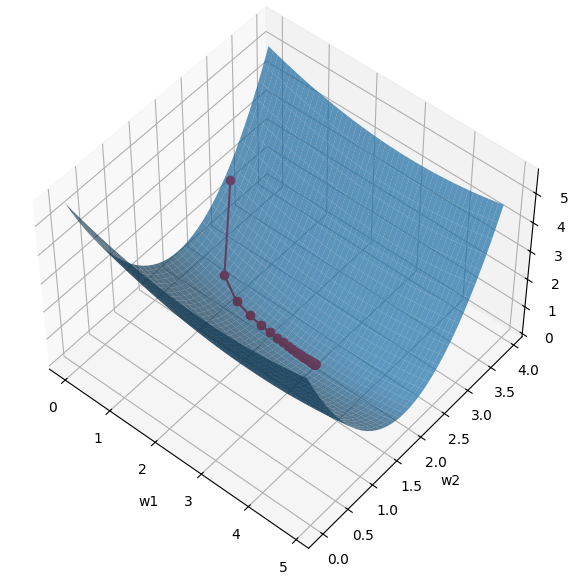

In [ ]:
# Draw the loss surface and the path to the optimal point.
m = 5
t = 0.1
w1, w2 = np.meshgrid(np.arange(0, m, t), np.arange(0, 4, t))
zs = np.array([loss([a,b]).numpy() for [a, b] in zip(np.ravel(w1), np.ravel(w2))])
z = zs.reshape(w1.shape)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Draw the surface of the loss function
ax.plot_surface(w1, w2, z, alpha=0.7)

# Dwaw the path to the optimal point.
L = np.array([loss([a, b]).numpy() for [a, b] in zip(x, y)])
ax.plot(x, y, L, marker='o', color="r")

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('loss')
ax.azim = -50
ax.elev = 50
plt.show()

### Root Mean Square Propagation (RMSProp) Optimizer

- The **RMSProp** optimizer was developed to address a **notable limitation in the Adagrad algorithm**, which tends to **reduce learning rates too rapidly as training progresses.**
- While Adagrad accumulates squared gradients over all iterations, **causing the effective learning rate to diminish too quickly,** RMSProp modifies this approach for smoother and more stable learning rate decay.

#### Intuition

- You can think of RMSProp as a **leaky cache** that `forgets` old gradients gradually, focusing on recent trends.
- This is **analogous to smoothing noisy data**, where **recent observations are weighted more heavily** to capture current behavior while ignoring outdated fluctuations.

#### Mathematical Formulation

- Instead of summing all past squared gradients, RMSProp computes an **exponentially weighted moving average** of the squared gradients.
- This moving average, denoted $ G_t $ or the cache, combines a fraction of the **previous moving average** with a fraction of the **most recent squared gradient**.
- The formula for updating the moving average at iteration $ t $ is:

  $$
  G_t = \rho G_{t-1} + (1 - \rho) g_t^2
  $$

  Where:
  - $ \rho $ (decay rate) is a hyperparameter close to 1 (typically 0.9, 0.99, or 0.999),
  - $ g_t $ is the current gradient,
  - $ G_t $ reflects a smoothed accumulation giving more weight to recent gradients.

- $ \rho $ controls how much previous squared gradients affect the current average.
  - A **larger $ \rho $** means the optimizer `remembers` past gradients longer, leading to smoother but slower decay.
  - A **smaller $ \rho $** weights recent gradients more heavily, allowing faster adaptation but potentially noisier updates.
- The learning rate for **each parameter is scaled inversely proportional to the square root of $ G_t $**, ensuring that parameters with large recent gradients get their learning rate reduced, while parameters with smaller gradients maintain relatively higher learning rates.
- Formally, the parameter update is:

  $$
  w_{t+1} = w_t - \frac{\eta}{\sqrt{G_t + \epsilon}} g_t
  $$

  Where:
  - $ \eta $ is the base learning rate,
  - $ \epsilon $ is a small constant to prevent division by zero.

#### The Initialization of $G_t$: Impact of Zero Initialization

- It is tempting to initialize the cache $ G_0 $ to **zero**, can cause unintended effects.
- Suppose you choose a **decay rate $ \rho = 0.999 $**, which is typical.
- The first cache update becomes:

  $$
  G_1 = 0.999 \times 0 + (1 - 0.999) \times g_1^2 = 0.001 \times g_1^2
  $$

- This value $0.001 \times g_1^2$ in the denominator (modulo epsilon) makes the effective learning rate at $ t=1 $ **artificially very large**, since dividing by a very small number amplifies the step size.
- This can destabilize the optimization early unless you compensate by **lowering the base learning rate**.

#### Alternative Initialization: $G_t$ Set to One

- One practical solution is to initialize the cache value $ G_0 = 1 $ instead of zero.
- This makes the effective learning rate at the start roughly equal to the base learning rate $ \eta $, avoiding the explosion from small denominators.
- Mathematically, it approximates the update as if RMSProp were not adapting the learning rate, meaning:

  $$
  \text{effective learning rate} \approx \frac{\eta}{\sqrt{1}} = \eta
  $$

- The existing frameworks differ on this:
  - **TensorFlow** often initializes the cache to one.
  - **Keras** tends to initialize it to zero.
- Both approaches have been widely adopted and show empirical validity.

#### Advantages of RMSProp

- **Smooth learning rate decay:** The exponential moving average softens the learning rate reduction compared to Adagrad’s aggressive decay, maintaining effective updates deeper into training.
- **Adapts to recent gradient behavior:** Prioritizes recent gradients, making it more responsive to changes than simply accumulating all past gradients.
- **Prevents vanishing learning rates:** Stabilizes training by preventing the learning rate from decaying to near zero too rapidly.

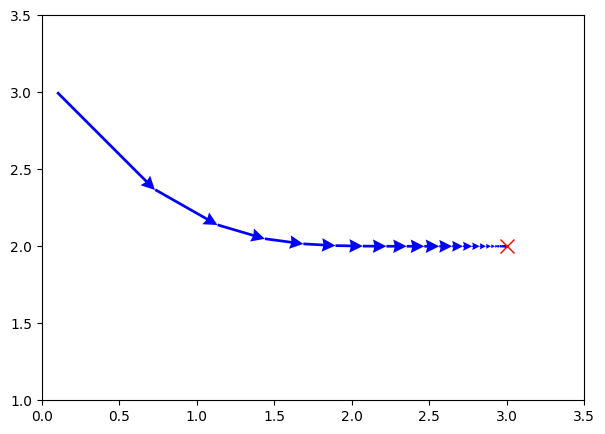

In [ ]:
import numpy as np
import tensorflow as tf
from keras import optimizers
import matplotlib.pyplot as plt

# initial point and the target point
w0 = np.array([0.1, 3], dtype='float32') # initial point
wt = np.array([3, 2], dtype='float32')   # target point
w = tf.Variable(w0)                      # (w1, w2)

# Adagrad
opt = optimizers.RMSprop(learning_rate = 0.2, rho=0.9)

def loss(w):
    return tf.reduce_sum(tf.square(w - wt) * [0.1, 1.2])

path = [w.numpy()]
for i in range(80):
    # perform automatic differentiation
    with tf.GradientTape() as tape:
        # the gradient of w1-axis is small,
        # and the gradient of w2-axis is large.
        dw = tape.gradient(loss(w), [w])

    # update w by gradient descent
    opt.apply_gradients(zip(dw, [w]))
    path.append(w.numpy())
path = np.array(path)

# visually check the path to the optimal point.
x, y = path[:, 0], path[:, 1]
plt.figure(figsize=(7, 5))
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
           color='blue', scale_units='xy',
           scale=1, width=0.005,
           headwidth=5)
plt.plot(wt[0], wt[1], marker='x', markersize=10, color='red')
plt.xlim(0, 3.5)
plt.ylim(1.0, 3.5)
plt.show()

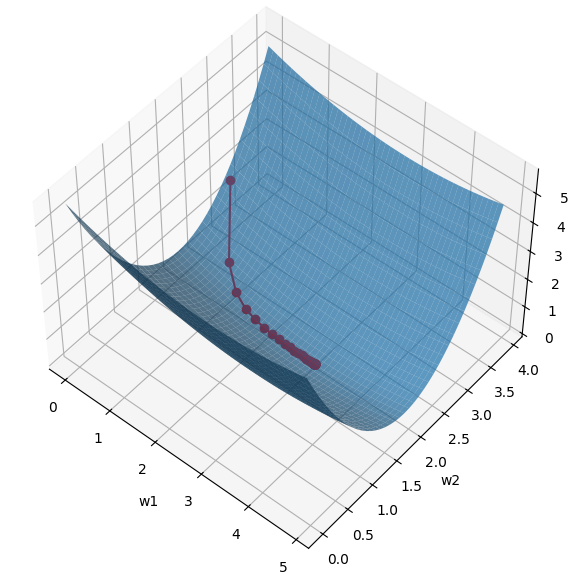

In [ ]:
# Draw the loss surface and the path to the optimal point.
m = 5
t = 0.1
w1, w2 = np.meshgrid(np.arange(0, m, t), np.arange(0, 4, t))
zs = np.array([loss([a,b]).numpy() for [a, b] in zip(np.ravel(w1), np.ravel(w2))])
z = zs.reshape(w1.shape)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Draw the surface of the loss function
ax.plot_surface(w1, w2, z, alpha=0.7)

# Dwaw the path to the optimal point.
L = np.array([loss([a, b]).numpy() for [a, b] in zip(x, y)])
ax.plot(x, y, L, marker='o', color="r")

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('loss')
ax.azim = -50
ax.elev = 50
plt.show()

### ADADELTA Optimizer — Improvements over Adagrad

The **ADADELTA optimizer** is an adaptive learning rate optimization algorithm designed to overcome limitations in the original Adagrad method.
  1. the continual decay of learning rates throughout training, and
  2. the need for a manually selected global learning rate.

**Adagrad** adapts the learning rate for each parameter by accumulating the sum of squared gradients since the start of training:
  $$
  G_t = G_{t-1} + [g_t]^2
  $$
  $$
  w_{t+1} = w_t - \frac{\alpha}{\sqrt{G_t + \epsilon}} g_t
  $$
- **Problem:** Because each squared gradient is non-negative, $ G_t $ only increases or stays constant over time. Given enough iterations, the denominator becomes extremely large, shrinking the effective learning rate and slowing (or even halting) progress.

#### **Idea 1:** Accumulate Over Window: Local Accumulation with an Exponential Moving Average

ADADELTA addresses this by **restricting the accumulated sum**:

- Rather than accumulating squared gradients across *all* steps, ADADELTA uses a **moving window** — specifically, an **exponentially decaying average** of past squared gradients:
  $$
  G_t = \rho G_{t-1} + (1-\rho)g_t^2
  $$
  where $ \rho $ is the decay rate (e.g., 0.95–0.99).
- This approach acts like a rolling window, where *recent* gradients have more influence, preventing $ G_t $ from growing without bound and keeping the effective learning rate from decaying too fast.

- The update step is:
  $$
  w_{t+1} = w_t - \frac{\eta}{\mathrm{RMS}(g_t)} g_t
  $$
  where:
  $$
  \mathrm{RMS}(g_t) = \sqrt{G_t + \epsilon}
  $$
  with $ \epsilon $ a small constant for stability.

#### Idea 2: Correct Units with Hessian Approximation



Another refinement in ADADELTA is **matching the units** of parameter updates with the parameters themselves (unit correction), inspired by Newton’s method:

- In methods like SGD, Momentum, or Adagrad, the update can have inconsistent units since it is derived from the gradient ($ \partial L/\partial w $), not from the parameter $ w $.
- Newton’s method, however, uses both the gradient and an approximation of the local curvature (the Hessian) to match units:
  $$
  \Delta w \propto H^{-1}g \propto \frac{\partial L/\partial w}{\partial^2 L/\partial w^2}
  $$
- ADADELTA **approximates the curvature** by maintaining an additional exponentially decaying RMS of *previous parameter updates* ($ \mathrm{RMS}(\Delta w_{t-1}) $):

  - **Exponential average of squared updates**:
    $$
    S_t = \rho S_{t-1} + (1 - \rho) (\Delta w_{t-1})^2
    $$
  - **Root mean square**:
    $$
    \mathrm{RMS}(\Delta w_{t-1}) = \sqrt{S_{t-1} + \epsilon}
    $$
  - The *final update rule* combines both moving averages:
    $$
    \Delta w_t = -\frac{\mathrm{RMS}(\Delta w_{t-1})}{\mathrm{RMS}(g_t)} g_t
    $$
    $$
    w_{t+1} = w_t + \Delta w_t
    $$

  - This ensures that both numerator and denominator are in matching units, mirroring the corrections made by Newton’s method but cheaply approximated from first-order information.

#### Advantages of AdaGrad


- **Prevents premature stagnation** seen in Adagrad by keeping the effective learning rate stable even after many updates.
- **Automatically adjusts magnitudes** so users rarely need to tune the learning rate explicitly.
- Suitable for deep learning scenarios with varying gradient scales and non-stationary data.

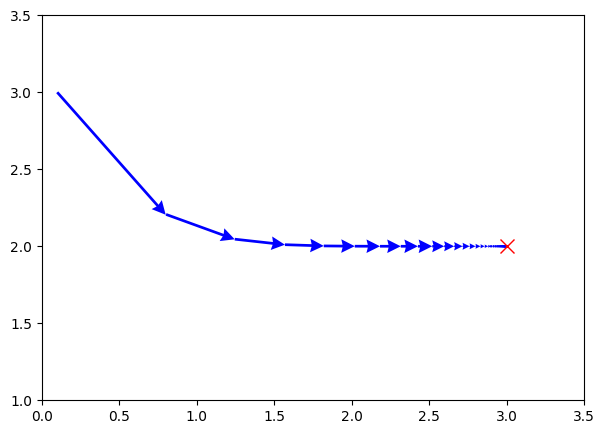

In [ ]:
import numpy as np
import tensorflow as tf
from keras import optimizers
import matplotlib.pyplot as plt

# initial point and the target point
w0 = np.array([0.1, 3], dtype='float32') # initial point
wt = np.array([3, 2], dtype='float32')   # target point
w = tf.Variable(w0)                      # (w1, w2)

# Adagrad
opt = optimizers.Adagrad(learning_rate = 0.8)

def loss(w):
    return tf.reduce_sum(tf.square(w - wt) * [0.1, 1.2])

path = [w.numpy()]
for i in range(80):
    # perform automatic differentiation
    with tf.GradientTape() as tape:
        # the gradient of w1-axis is small,
        # and the gradient of w2-axis is large.
        dw = tape.gradient(loss(w), [w])

    # update w by gradient descent
    opt.apply_gradients(zip(dw, [w]))
    path.append(w.numpy())
path = np.array(path)

# visually check the path to the optimal point.
x, y = path[:, 0], path[:, 1]
plt.figure(figsize=(7, 5))
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
           color='blue', scale_units='xy',
           scale=1, width=0.005,
           headwidth=5)
plt.plot(wt[0], wt[1], marker='x', markersize=10, color='red')
plt.xlim(0, 3.5)
plt.ylim(1.0, 3.5)
plt.show()

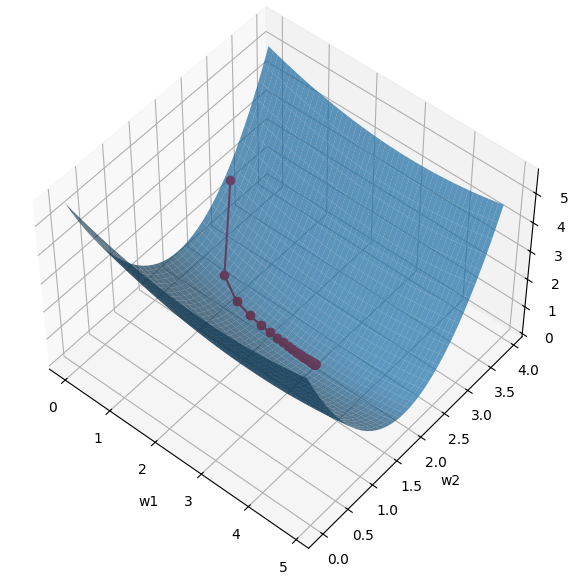

In [ ]:
# Draw the loss surface and the path to the optimal point.
m = 5
t = 0.1
w1, w2 = np.meshgrid(np.arange(0, m, t), np.arange(0, 4, t))
zs = np.array([loss([a,b]).numpy() for [a, b] in zip(np.ravel(w1), np.ravel(w2))])
z = zs.reshape(w1.shape)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Draw the surface of the loss function
ax.plot_surface(w1, w2, z, alpha=0.7)

# Dwaw the path to the optimal point.
L = np.array([loss([a, b]).numpy() for [a, b] in zip(x, y)])
ax.plot(x, y, L, marker='o', color="r")

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('loss')
ax.azim = -50
ax.elev = 50
plt.show()

## The Adam Optimizer

Adam optimizer, short for **Adaptive Moment Estimation**, which has become the default and **most widely used optimization method** for training deep neural networks today. Adam combines RMSprop and Momentum, offers robust performance with **minimal hyperparameter tuning**.
- It is **highly effective** in a variety of settings and works well `out of the box`.
- Requires **little hyperparameter tuning** default values often suffice.
- Provides **adaptive learning rates** per parameter automatically, handling sparse or noisy gradients efficiently.
- Combines the advantages of **momentum** and **RMSProp** optimizers.

Adam integrates two main techniques:

1. **Momentum (First Moment Estimation):**  
   Maintains a moving average of past gradients, capturing the direction and smoothing updates.

2. **RMSProp (Second Moment Estimation):**  
   Maintains a moving average of the squared gradients, adjusting learning rates based on gradient magnitudes to stabilize updates.

#### Momentum and RMSProp Updates

- **Momentum:**

  Update the momentum term $ m $ using a decay rate $ \beta $ and the current gradient $ g_t $:

  $$
  m_t = \beta m_{t-1} + (1 - \beta) g_t
  $$

  Update parameters $w$ by stepping in the negative direction of $m_t $ scaled by the learning rate $ \eta $:

  $$
  w_{t+1} = w_{t} - \eta m_{t}
  $$

- **RMSProp:**

  Update the cache $ G_{t} $, a running average of squared gradients, using decay rate $ \rho $:

  $$
  G_{t} = \rho G_{t-1} + (1 - \rho) g_t^2
  $$

  Update parameters with scaled gradient, dividing by the square root of $ G_t $ plus a small constant $ \epsilon $:

  $$
  w_{t+1} = w_{t} - \frac{\eta}{\sqrt{G_{t} + \epsilon}} g_t
  $$

#### Building Adam: Combining Momentum and RMSProp

Adam combines these two concepts into a single update rule:

- Compute a moving average of gradients ($ m $, first moment estimate).
- Compute a moving average of squared gradients ($ G $, second moment estimate).
- Use **bias corrections to account for initialization effects**.
- Update parameters using $ m $ divided by the square root of $ G $, scaled by the learning rate $ \eta $:

$$
w_{t} = w_{t-1} - \eta \frac{ \hat{m_t} }{ \sqrt{ \hat{G_t} } + \epsilon }
$$

  where $ \hat{m_t} $ and $ \hat{G_t} $ are bias-corrected estimates.

#### Bias Correction

- The recursive formula for **EWMA depends on previous average values**, which are **typically initialized to zero.**
- This **causes a bias towards zero in early iterations**, leading to underestimated averages at the start of training.
- For instance, at the first time step, the moving average is just a fraction of the current input, skewed by that initial zero.
  - With $ \beta = 0.99 $:
  - At $ t=1 $, the uncorrected average is:
$$
m_1 = 0.01 \times x_1
$$
- Adam corrects this initialization bias by dividing the moving averages by a factor involving the decay rate raised to the power of the current time step:

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t} \quad \text{and} \quad \hat{G}_t = \frac{G_t}{1 - \rho^t}
$$

- Since $ \beta, \rho $ are less than 1, **the denominators approach 1 as $ t $ becomes large, making the bias correction negligible for later steps.**
  - Bias-corrected:

$$
\hat{m}_1 = \frac{m_1}{1 - 0.99} = x_1
$$

This perfectly corrects the bias.
- For small $ t $, this correction is critical to produce unbiased estimates, effectively `removing` the initial zero-conditioning effect.

#### Practical Considerations

- Adam’s default settings are robust and typically work well across problems:
  - Learning rate $ \eta = 10^{-3} $
  - Decay rate for first moment $ \beta = 0.9 $
  - Decay rate for second moment $ \rho = 0.999 $
  - Small constant $ \epsilon = 10^{-8} $

- These defaults are built into most deep learning libraries.

  - Adam is generally a strong default optimizer but may not always outperform SGD with momentum.
  - Empirical experimentation is essential to determine the best optimizer for a particular dataset or task.
  - Regularization and warm restarts can be combined with Adam for further training improvements.
  - Despite some criticism about convergence in certain cases, **Adam remains the go-to optimizer in practice**.

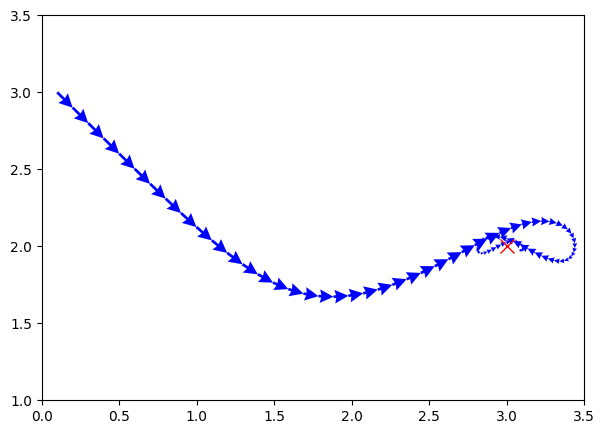

In [ ]:
import numpy as np
import tensorflow as tf
from keras import optimizers
import matplotlib.pyplot as plt

# initial point and the target point
w0 = np.array([0.1, 3], dtype='float32') # initial point
wt = np.array([3, 2], dtype='float32')   # target point
w = tf.Variable(w0)                      # (w1, w2)

# Adagrad
opt = optimizers.Adam(learning_rate = 0.1, beta_1=0.9, beta_2=0.9)

def loss(w):
    return tf.reduce_sum(tf.square(w - wt) * [0.1, 1.2])

path = [w.numpy()]
for i in range(80):
    # perform automatic differentiation
    with tf.GradientTape() as tape:
        # the gradient of w1-axis is small,
        # and the gradient of w2-axis is large.
        dw = tape.gradient(loss(w), [w])

    # update w by gradient descent
    opt.apply_gradients(zip(dw, [w]))
    path.append(w.numpy())
path = np.array(path)

# visually check the path to the optimal point.
x, y = path[:, 0], path[:, 1]
plt.figure(figsize=(7, 5))
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
           color='blue', scale_units='xy',
           scale=1, width=0.005,
           headwidth=5)
plt.plot(wt[0], wt[1], marker='x', markersize=10, color='red')
plt.xlim(0, 3.5)
plt.ylim(1.0, 3.5)
plt.show()

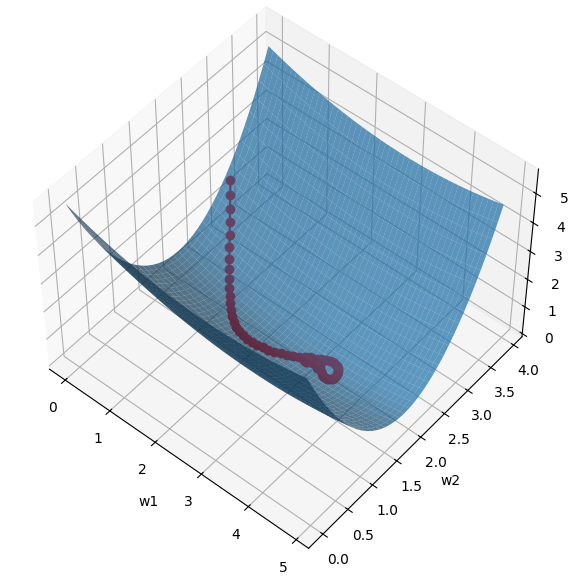

In [ ]:
# Draw the loss surface and the path to the optimal point.
m = 5
t = 0.1
w1, w2 = np.meshgrid(np.arange(0, m, t), np.arange(0, 4, t))
zs = np.array([loss([a,b]).numpy() for [a, b] in zip(np.ravel(w1), np.ravel(w2))])
z = zs.reshape(w1.shape)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Draw the surface of the loss function
ax.plot_surface(w1, w2, z, alpha=0.7)

# Dwaw the path to the optimal point.
L = np.array([loss([a, b]).numpy() for [a, b] in zip(x, y)])
ax.plot(x, y, L, marker='o', color="r")

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('loss')
ax.azim = -50
ax.elev = 50
plt.show()